In [ ]:
def transform_MIDAS(df):
    # --- Define columns to extract ---
    colNames = ["FECHA", "Y_PREDICCION", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3", "MODEL"]
    colNames2 = ["FECHA", "Y_PRONOSTICOS", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3", "MODEL"]
    colNames3 = ["FECHA", "Y_HIST", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3"]

    df1 = df[colNames] #df["Y_PREDICCION"].notna()]
    df1["Y_PREDICCION"] = df1["Y_PREDICCION"].astype(float) 
    df2 = df[colNames2] #f["Y_PRONOSTICOS"].notna()
    df2["Y_PRONOSTICOS"] = df2["Y_PRONOSTICOS"].astype(float)
    df2.columns = colNames  
    df3 = df[df.MODEL == "BayesianRidge"][colNames3]
    df3["Y_HIST"] = df3["Y_HIST"].astype(float)
    combined_df = pd.concat([df1, df2], ignore_index=True)
    # --- Reorder columns: move Y_PREDICCION next to MODEL ---
    cols = combined_df.columns.tolist()
    y_pred_idx = cols.index("Y_PREDICCION")
    model_idx = cols.index("MODEL")
    cols.insert(model_idx + 1, cols.pop(y_pred_idx))
    combined_df = combined_df[cols]
    combined_df["Y_PREDICCION"] = combined_df["Y_PREDICCION"].astype(float)

    res = pd.pivot_table(combined_df, index=["FECHA", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3"], columns= "MODEL", values= "Y_PREDICCION", aggfunc= "mean" ).reset_index()
    res = res.merge(df3, on = ["FECHA", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3"], how = "outer", validate = "1:1")
    res = res.rename(columns = {"FECHA":"MesAnio", "NOMBREGRUPOESTADISTICO3": "NombreGrupoEstadistico3", "NOMBRESUBDIRECCION": "NombreSubdireccion", "Y_HIST":"Y_HIST2"})
    return res


def load_fact_pvo_pv():
    print("Consultando PV")
    pv = data_bq(QUERY_HISTORICO_PV)
    pv["id"] = pv[[ "NombreGrupo", "NombreDireccion", "NombreSubdireccion", "NombreGrupoEstadistico1", "NombreGrupoEstadistico2", "NombreGrupoEstadistico3"]].astype(str).agg("_".join, axis=1)

    print("Consultando PV")
    pvo = data_bq(QUERY_HISTORICO_PVO)
    pvo["id"] = pvo[[ "NombreGrupo", "NombreDireccion", "NombreSubdireccion", "NombreGrupoEstadistico1", "NombreGrupoEstadistico2", "NombreGrupoEstadistico3"]].astype(str).agg("_".join, axis=1)

    print("Consultando FACT")
    fact = data_bq(QUERY_HISTORICO_FACTURACION)
    fact["id"] = fact[[ "NombreGrupo", "NombreDireccion", "NombreSubdireccion", "NombreGrupoEstadistico1", "NombreGrupoEstadistico2", "NombreGrupoEstadistico3"]].astype(str).agg("_".join, axis=1)
    print(fact.id.nunique())

    out = pvo.merge(pv, how = "outer", on = ["MesAnio","id","NombreGrupo","NombreDireccion","NombreSubdireccion","NombreGrupoEstadistico1","NombreGrupoEstadistico2","NombreGrupoEstadistico3"], validate = "1:1")
    print(out.id.nunique())

    out = out.merge(fact, how = "outer", on = ["MesAnio","id","NombreGrupo","NombreDireccion","NombreSubdireccion","NombreGrupoEstadistico1","NombreGrupoEstadistico2","NombreGrupoEstadistico3"], validate = "1:1")
    print(out.id.nunique())

    for i in ["toneladas_pvo","toneladas_plan_ventas","toneladas_facturadas"]:
        # imputamos nulos con np.nan
        out[i] = out[i].astype(float).fillna(np.nan)

        #limitamos el valor absoluto cercano a cero a cero
        out[i] = np.where(out[i].abs()<0.000001,0, out[i] )

    out["MesAnio"] = pd.to_datetime(out["MesAnio"])

    # SELECICONAMOS G32 DEL
    g32del =  [' 8X19-26 AA GALV QUERETARO', '1X19-36 NEG QUERETARO','ACCESORIOS CROSBY QUERETARO', 'AL GALV CD', 'AL FORJAS C/TRAT (CHQ)',
                'AL FORJAS C/TRAT', 'A.GALV. FINO', 'ALAMBRE PARA GAVIONES','ALAMBRE ESTAÑADO', 'SAW CUT', 'ALAMBRE PULIDO 25-29', 'REC IND (CHQ)',
                'REFACCIONES GRAPADORAS', 'PROTECTOR DE VENTANA', 'CASTILLO DOB.','CABLE DE REFUERZO', 'REC IND FINO', 'CLAVO PARA HERRAR',
                '6X19-26 AF NEG HOUSTON', 'PACKAGED', 'A. GALV. A.C. P/ CABLE', 'TRENZA PARA RESORTE', 'VALLA DEACERO', '8X31-41 AA NEG QUERETARO',
                'INDUSTRIAL TOOLS', 'JOIST HANGER NAILS', 'DERECHO DE VIA','CUT STOCK REBAR', 'GRAPA TAPICERA', 'HEX-NETTING INDUSTRIAL'
                ]
    #  AGREGAMOS ALGUNOS FILTROS...
    out = out[~out.NombreDireccion.isin(['ABAST. EXPORT', 'ABASTECIMIENTOS', 'DAL Y TRANSPORTE GRUPO DEACERO','IIDEA NACIONAL', 'H&H IRON AND METAL INC.', 'MAQUILAS'])]
    out = out[~out.NombreSubdireccion.isin(['EXCEDENTES ACEROS', 'EXCEDENTES ALAMBRES', 'DSS NO METALICOS ', 'DEACERO-MID CONTINENT', 'FILIALES CANADA', 'RESTO ALAMBRES', 'RESTO INGETEK'])]
    out = out[~out.NombreGrupoEstadistico1.isin(['CHATARRA', 'LOGÍSTICA', 'SEGUNDAS', 'INTERNAS PRODUCCION ', "DEACERO POWER"])]
    out = out[~out.NombreGrupoEstadistico2.isin(['2D&3D', 'ALAMBRON', 'ALAMBRON OTROS', 'AMARRADORA DE VARILLA', 'SEGUNDAS / EXCEDENTES', 'PILOTES', 'SERVICIOS INGETEK', 'VARILLA FERRETERA'])]
    out = out[~out.NombreGrupoEstadistico3.isin(g32del)]

    return out

def duplicados(FACT):
    #ELIMINAMOS DUPLICADOS DE FILIALES....
    FACT["id2"] = FACT[["NombreSubdireccion", "NombreGrupoEstadistico3"]].astype(str).agg("_".join, axis=1)
    to_compare = FACT.groupby("id2")["NombreDireccion"].nunique()
    vals_duplicated = to_compare [to_compare>1].index
    #x = FACT[FACT["id2"].isin(vals_duplicated) & (FACT.MesAnio == "2025-08-01")].groupby(["id2","NombreGrupo", "NombreDireccion"]).agg({"toneladas_facturadas":"sum","toneladas_pvo" :"sum"})#.to_csv("file_csv.csv")
    FACT = FACT[~(FACT.id2.isin(vals_duplicated) & (FACT.NombreDireccion == "FILIALES"))]
    return FACT


def calcular_tp_meses(df, lags_years):
    #funcioon que promedia mismos meses de los ultimos n años...
    # Crear los lags usando .transform()
    df["toneladas_facturadas2"] =df["toneladas_facturadas"].fillna(0) 
    
    # Crear los lags correctamente
    for lag in range(1, lags_years + 1):
        df[f'lag_{lag}'] = df.groupby("id")['toneladas_facturadas'].transform(lambda x: x.shift(lag * 12))

    # Calcular TP_MESES como el promedio de los lags
    lag_cols = [f'lag_{lag}' for lag in range(1, lags_years + 1)]
    df['TP_MESES'] = df[lag_cols].mean(axis=1)
    df = df.drop(columns =lag_cols )

    return df.drop(columns = "toneladas_facturadas2")


def calcular_tp_movil(FACT , date_today):
    # funci que calcula media movil para train y teest 
    LIST_DIR = [] 
    grouped = FACT.groupby('id')
    for a_, data in grouped:
        #print(a_, len(LIST_DIR))
        data = data[["MesAnio","toneladas_facturadas"]].set_index("MesAnio")
        data["id"] = a_
        data["TP_MOVIL"] = None
        data["fcst"] = data.toneladas_facturadas
        for date in data.index:
            start_date = date - pd.DateOffset(months=7)
            end_date = date - pd.DateOffset(months=1)
            if date < date_today: 
                data.loc[date, "TP_MOVIL"] = data.loc[(data.index> start_date) & (data.index<= end_date) ,"toneladas_facturadas"].mean()
            else:
                data.loc[date, "fcst"] =  data.loc[(data.index > start_date) & (data.index<= end_date) ,"fcst"].mean()
            data["TP_MOVIL"] = np.where(data.index <date_today, data["TP_MOVIL"], data["fcst"] )
        LIST_DIR.append(data[["id", "TP_MOVIL"]])
    return pd.concat(LIST_DIR).reset_index()
    

def add_zeros(df):
     
    print(df.shape)
    fechas = df['MesAnio'].unique()
    id = df['id'].unique()

    # Generar todas las combinaciones posibles
    combinaciones = pd.DataFrame(list(itertools.product(fechas, id)), columns=['MesAnio',"id"])

    for i, col  in enumerate([ "NombreGrupo", "NombreDireccion", "NombreSubdireccion", "NombreGrupoEstadistico1", "NombreGrupoEstadistico2", "NombreGrupoEstadistico3"]):
        # agregamos columnas en el df aplicando el split
        print(i, col)
        combinaciones[col] = combinaciones["id"].str.split("_").apply(lambda x:x[i])

    # Unir con el DataFrame original
    df_completo = pd.merge(combinaciones, df, on = ["MesAnio","id","NombreGrupo","NombreDireccion","NombreSubdireccion","NombreGrupoEstadistico1","NombreGrupoEstadistico2","NombreGrupoEstadistico3"], how='left')
    
    df_completo["valid_ton"] = df_completo[["toneladas_pvo","toneladas_plan_ventas","toneladas_facturadas"]].fillna(0).sum(axis = 1)

    df_completo = df_completo.sort_values(by=['id', 'MesAnio'])
    df["toneladas_facturadas"] =df["toneladas_facturadas"].fillna(0)

    # TP MESES -----------------------------------------------------------------------------------------------
    df_completo = calcular_tp_meses(df_completo, lags_years = 3)
    #df_completo = df_completo.set_index("MesAnio", drop=True)

    # TP MOVIL -----------------------------------------------------------------------------------------------
    TPMOVIL = calcular_tp_movil(FACT,date_today)
    df_completo = df_completo.merge(TPMOVIL, how = "left", on = ["id", "MesAnio"], validate= "1:1")

    #filtramos ids conflictivos
    df_completo["id2"] = df_completo[["NombreSubdireccion", "NombreGrupoEstadistico3"]].astype(str).agg("_".join, axis=1)
    x = df_completo[(df_completo.NombreGrupo == "TRASPASOS E INTEREMPRESAS") & (df_completo.NombreDireccion == "FILIALES")].groupby("id2").agg({"toneladas_facturadas":"sum","toneladas_pvo" :"sum"})
    ids2del =  x[x["toneladas_pvo"] == 0].index
    df_completo = df_completo[~df_completo.isin(ids2del)]

    df_completo = duplicados(df_completo)
    #FILTRAMOS SOLO 2025 EN ADELANTE    ------------------------------
    df_completo = df_completo[df_completo["MesAnio"].dt.year >=2025 ]
    print(df_completo.id2.nunique())
    return df_completo


In [218]:
import pandas as pd 
import numpy as np 
import os
from google.cloud import bigquery
from google.oauth2 import service_account
from datetime import datetime
from dateutil.relativedelta import relativedelta
import itertools
from functions import *
from constants import *
from datetime import datetime
pd.set_option('display.max_columns', None)

# declaramos las credenciales al entorno de desarollo
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\\..\\bd\\0_docs\\datahub-deacero-adojeda.json"

# Crear date_today como el primer día del mes actual
now = datetime.now() - relativedelta(days= 4)

date_today = datetime(now.year, now.month, 1)

# Crear date_last_6m como seis meses antes de date_today
date_last_6m = date_today - relativedelta(months=6)

# Crear date_forecas como seis meses después de date_today
date_forecas = date_today + relativedelta(months=6)

# Mostrar las fechas
print("date_today:", date_today.strftime("%Y-%m-%d"))

print("date_last_6m:", date_last_6m.strftime("%Y-%m-%d"))

print("date_forecas:", date_forecas.strftime("%Y-%m-%d"))

date_today: 2025-09-01
date_last_6m: 2025-03-01
date_forecas: 2026-03-01


## Generamos Resultados Modelo MIDAS V1

In [217]:
LIST_DIR ="../../bd/Facturacion BQ/MIDAS/20250918"

list_df = []
for num, path in  enumerate(os.listdir(LIST_DIR)):
    print(num, path)
    df =pd.read_excel(LIST_DIR + "/" + path)
    list_df.append(df)
    del df
base = pd.concat(list_df)
del list_df

base_t = transform_MIDAS(base)

base_t['WOC_v1'] = base_t[['BayesianRidge', 'GradientBoostingRegressor', 'KNeighborsRegressor','LGBMRegressor', 'RandomForestRegressor', 'Ridge', 'SVR','XGBRegressor']].fillna(0).mean(axis = 1)
base_t.sample(5)

0 outputs_BayesianRidge_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250918_182632.csv
1 outputs_GradientBoostingRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250918_190826.csv
2 outputs_KNeighborsRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250918_185634.csv
3 outputs_LGBMRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250918_183654.csv
4 outputs_RandomForestRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250918_174738.csv
5 outputs_Ridge_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250918_184638.csv
6 outputs_SVR_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250918_181558.csv
7 outputs_XGBRegressor_FORECAST_NombreSubdireccion_ToneladasFacturadas_20250918_180608.csv


,MesAnio,NombreSubdireccion,NombreGrupoEstadistico3,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,Y_HIST2,WOC_v1
1960,2024-12-01,MAYORISTAS ACEROS,VIGAS IPR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.78200,0.000000
2567,2025-01-01,PERFILES NACIONAL,CRIBA ORNAMENTAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.49600,0.000000
2539,2025-01-01,NORTE,SEMI-FLECHA COM.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.22400,0.000000
4195,2025-04-01,SOLUCIONES,VARILLA HABILITADA/ARMADA,82.1000,65.8699,66.4473,280.8020,70.8874,81.7845,110.9468,67.560204,93.88852,103.299763
4151,2025-04-01,PERFILES NACIONAL,MALLA SOLDADA 44 Y 66,85.2671,90.4513,97.7398,115.2312,93.4407,84.7811,74.7581,91.742302,23.48100,91.676450


In [275]:
base_t.groupby("MesAnio").sum(numeric_only = True).round(0)

,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,Y_HIST2,WOC_v1
MesAnio,,,,,,,,,,
2024-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190709.0,0.0
2024-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200189.0,0.0
2024-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203749.0,0.0
2024-12-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,173644.0,0.0
2025-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,225975.0,0.0
2025-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206647.0,0.0
2025-03-01,215598.0,208217.0,209271.0,202317.0,208266.0,208131.0,206675.0,213742.0,212922.0,209027.0
2025-04-01,209053.0,204745.0,204994.0,195729.0,204944.0,201931.0,207437.0,207231.0,204263.0,204508.0
2025-05-01,206637.0,201215.0,201635.0,201647.0,200644.0,201643.0,201904.0,203019.0,205227.0,202293.0


## GENERAMOS HISTORICOS DE PV, PVO Y FACTURACION DESDE BQ

In [220]:
FACT = load_fact_pvo_pv()
FACT = add_zeros(FACT)
FACT.sample(5)

2777
2777
2777
2777
2777
(78512, 11)
0 NombreGrupo
1 NombreDireccion
2 NombreSubdireccion
3 NombreGrupoEstadistico1
4 NombreGrupoEstadistico2
5 NombreGrupoEstadistico3
(106428, 12)
2088


,MesAnio,id,NombreGrupo,NombreDireccion,NombreSubdireccion,NombreGrupoEstadistico1,NombreGrupoEstadistico2,NombreGrupoEstadistico3,toneladas_pvo,toneladas_plan_ventas,toneladas_facturadas,valid_ton,TP_MESES,TP_MOVIL,id2
98331,2025-02-01,USA_EUA - CANADA_INDUSTRIAL WIRE_ALAMBRON_ALAM...,USA,EUA - CANADA,INDUSTRIAL WIRE,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,NaN,0.00000,0.00000,0.00000,NaN,0.0,INDUSTRIAL WIRE_ALAMBRON CONSTRUCCION
54336,2025-09-01,DEACERO SOLUTIONS_INGETEK_COMERCIAL MEXICO INF...,DEACERO SOLUTIONS,INGETEK,COMERCIAL MEXICO INFRAESTRUCTURA,PERFILES,REDONDOS Y CUADRADOS,REDONDOS COMERCIALES,NaN,NaN,NaN,0.00000,0.000000,0.0,COMERCIAL MEXICO INFRAESTRUCTURA_REDONDOS COME...
55660,2025-10-01,DEACERO SOLUTIONS_INGETEK_DEFENSA_MALLAS Y ALA...,DEACERO SOLUTIONS,INGETEK,DEFENSA,MALLAS Y ALAMBRES,FERRETEROS,CLAVO 1 - 1 1/2,NaN,NaN,0.00000,0.00000,0.066667,0.0,DEFENSA_CLAVO 1 - 1 1/2
14003,2025-03-01,ALAMBRES_ALAMBRES_CENTRO SUR_MALLAS Y ALAMBRES...,ALAMBRES,ALAMBRES,CENTRO SUR,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,REJA CLASICA,300.82759,300.82768,256.11132,857.76659,314.875033,0.0,CENTRO SUR_REJA CLASICA
101426,2025-10-01,USA_EUA - CANADA_INDUSTRIAL WIRE_MALLAS Y ALAM...,USA,EUA - CANADA,INDUSTRIAL WIRE,MALLAS Y ALAMBRES,INDUSTRIAL GALV.,RETENIDAS INTERMEDIA,120.99999,120.00000,0.00000,240.99999,169.845327,0.0,INDUSTRIAL WIRE_RETENIDAS INTERMEDIA


In [222]:
FACT.groupby("MesAnio")[["toneladas_pvo","toneladas_plan_ventas","toneladas_facturadas"]].sum().round(0)

,toneladas_pvo,toneladas_plan_ventas,toneladas_facturadas
MesAnio,,,
2025-01-01,319541.0,309265.0,328487.0
2025-02-01,323747.0,330500.0,301610.0
2025-03-01,314116.0,311392.0,298606.0
2025-04-01,297967.0,299818.0,276743.0
2025-05-01,349645.0,351032.0,286634.0
2025-06-01,354625.0,349853.0,269711.0
2025-07-01,320277.0,318095.0,285686.0
2025-08-01,317894.0,311227.0,316012.0
2025-09-01,348233.0,363531.0,162138.0


# POP 
Proceso de Optimización de Pronósticos?

El siguiente notebook permite Optimizar los pronósticos de Subdir-GE3 para seleccionar el modelo más adecuado.

El modelo adecuado será aquel que minimicé el MAPE Deacero a nivel SKU BU - ej. **$min(MAPE_{Deacero})$**  Seleccionado entre los siguientes Modelos

* PVO
* BayesianRidge	
* GradientBoostingRegressor	
* KNeighborsRegressor	
* LGBMRegressor	
* RandomForestRegressor
* Ridge	
* SVR
* XGBRegressor
* Demmand Management 

### Consulta RESULTADOS MODELO MIDAS_V2

In [276]:
forecast = data_bq(QUERY_RESULTADOS_MODEL2)
print("CONSULTANDO RESULTADOS MODELO 2")
forecast.sort_index(inplace=True, ascending=True)

forecast["Y_HIST"] = forecast["Y_HIST"].astype(float)
forecast["Y_PREDICCION"] = forecast["Y_PREDICCION"].astype(float)
forecast["Y_PRONOSTICOS"] = forecast["Y_PRONOSTICOS"].astype(float)
forecast["Y_TEST"] = forecast["Y_TEST"].astype(float)

print(forecast.FECHA.value_counts().sort_index().tail(5))

out = transform_MIDAS(forecast)
print("TRANSFORMANDO DATOS")
out.sample(5)

out.MesAnio = pd.to_datetime(out.MesAnio) 
display(out.groupby("MesAnio").sum(numeric_only = True).round(0))
out = out.merge(base_t, how = "left", on = ["MesAnio","NombreSubdireccion","NombreGrupoEstadistico3"] ,validate = "1:1", suffixes=('', '_v1'))

out["MAX_MODEL"] = True
out = FACT.merge(out, how = "left", on = ["MesAnio","NombreSubdireccion","NombreGrupoEstadistico3"] ,validate = "1:1")

out["MAX_MODEL"] = out["MAX_MODEL"].fillna(False)

out.sample(5)

CONSULTANDO RESULTADOS MODELO 2
FECHA
2025-10-01    4208
2025-11-01    4208
2025-12-01    4208
2026-01-01    4208
2026-02-01    4208
Name: count, dtype: int64
TRANSFORMANDO DATOS


,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,Y_HIST2
MesAnio,,,,,,,,,
2024-09-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190709.0
2024-10-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200189.0
2024-11-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203749.0
2024-12-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,173644.0
2025-01-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,225975.0
2025-02-01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206647.0
2025-03-01,6.632213e+16,208141.0,207428.0,205109.0,207420.0,208359.0,203827.0,211576.0,212922.0
2025-04-01,1.475715e+23,203861.0,205725.0,202663.0,204735.0,201944.0,206010.0,204925.0,204263.0
2025-05-01,5.508392e+25,202187.0,207599.0,210821.0,200327.0,201833.0,202406.0,201760.0,205227.0


,MesAnio,id,NombreGrupo,NombreDireccion,NombreSubdireccion,NombreGrupoEstadistico1,NombreGrupoEstadistico2,NombreGrupoEstadistico3,toneladas_pvo,toneladas_plan_ventas,toneladas_facturadas,valid_ton,TP_MESES,TP_MOVIL,id2,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,Y_HIST2,BayesianRidge_v1,GradientBoostingRegressor_v1,KNeighborsRegressor_v1,LGBMRegressor_v1,RandomForestRegressor_v1,Ridge_v1,SVR_v1,XGBRegressor_v1,Y_HIST2_v1,WOC_v1,MAX_MODEL
14247,2026-01-01,DEACERO SOLUTIONS_INGETEK_COMERCIAL MEXICO INF...,DEACERO SOLUTIONS,INGETEK,COMERCIAL MEXICO INFRAESTRUCTURA,MALLAS Y ALAMBRES,NEGROS ANTAAC,ESCALERILLA,NaN,NaN,NaN,0.000,0.000000,0.0,COMERCIAL MEXICO INFRAESTRUCTURA_ESCALERILLA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
12138,2025-10-01,ALAMBRES_EXPORTACIÓN ALAMBRES_EXPORTACIÓN ALAM...,ALAMBRES,EXPORTACIÓN ALAMBRES,EXPORTACIÓN ALAMBRES,MALLAS Y ALAMBRES,FERRETEROS,CLAVO REFORZADO GALVANIZADO,NaN,0.0,0.000,0.000,1.000000,0.0,EXPORTACIÓN ALAMBRES_CLAVO REFORZADO GALVANIZADO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
5049,2025-06-01,ALAMBRES_ALAMBRES_GOBIERNO_MALLAS Y ALAMBRES_C...,ALAMBRES,ALAMBRES,GOBIERNO,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,REJA CONTEMPORANEA,0.0,0.0,0.000,0.000,0.250712,0.0,GOBIERNO_REJA CONTEMPORANEA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
5281,2025-04-01,ALAMBRES_ALAMBRES_GOBIERNO_MALLAS Y ALAMBRES_S...,ALAMBRES,ALAMBRES,GOBIERNO,MALLAS Y ALAMBRES,SISTEMAS CONSTRUCTIVOS,MALLA TALUD,NaN,NaN,27.510,27.510,NaN,0.0,GOBIERNO_MALLA TALUD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
24785,2025-08-01,USA_EUA - CANADA_CONSTRUCTION DISTRIBUTION_MAL...,USA,EUA - CANADA,CONSTRUCTION DISTRIBUTION,MALLAS Y ALAMBRES,SISTEMAS CONSTRUCTIVOS,STAR STUCCO 17,100.0,100.0,69.384,269.384,147.410000,0.0,CONSTRUCTION DISTRIBUTION_STAR STUCCO 17,77.0715,87.3303,79.9459,145.4112,110.8675,77.5711,155.0118,77.130501,69.384,77.5125,86.0438,79.9968,73.6756,111.3565,78.2066,155.319,75.558403,69.384,92.20865,True


### PROCESO POP

In [257]:
df = out.copy()

#FILTRO LIMITE INFERIOR
df = df [df.MesAnio >= date_last_6m]

#FILTRO LIMITE SUPERIOR?

df = df [df.MesAnio <= date_forecas]

df['Segmento'] = np.where ((df.MesAnio >= date_last_6m) & (df.MesAnio < date_today), "Validacion", "Pronostico")

# Agregando modelo WOC
#df['WOC'] = df.mean(numeric_only = True, axis = 1)
df['WOC'] = df[['BayesianRidge', 'GradientBoostingRegressor', 'KNeighborsRegressor','LGBMRegressor', 'RandomForestRegressor', 'Ridge', 'SVR','XGBRegressor']].fillna(0).mean(axis = 1)

df['WOC_v1'] = df[['BayesianRidge_v1', 'GradientBoostingRegressor_v1', 'KNeighborsRegressor_v1','LGBMRegressor_v1', 'RandomForestRegressor_v1', 'Ridge_v1', 'SVR_v1','XGBRegressor_v1']].fillna(0).mean(axis = 1)

df.groupby("MesAnio").Segmento.last()

MesAnio
2025-03-01    Validacion
2025-04-01    Validacion
2025-05-01    Validacion
2025-06-01    Validacion
2025-07-01    Validacion
2025-08-01    Validacion
2025-09-01    Pronostico
2025-10-01    Pronostico
2025-11-01    Pronostico
2025-12-01    Pronostico
2026-01-01    Pronostico
Name: Segmento, dtype: object

In [258]:
display(df.isna().sum())

# imputamos 0s
df.fillna(0, inplace=True)

display(df.isna().sum())

df.tail()

MesAnio                             0
id                                  0
NombreGrupo                         0
NombreDireccion                     0
NombreSubdireccion                  0
NombreGrupoEstadistico1             0
NombreGrupoEstadistico2             0
NombreGrupoEstadistico3             0
toneladas_pvo                   11892
toneladas_plan_ventas           11341
toneladas_facturadas             4898
valid_ton                           0
TP_MESES                         2667
TP_MOVIL                            0
id2                                 0
BayesianRidge                   17325
GradientBoostingRegressor       17325
KNeighborsRegressor             17325
LGBMRegressor                   17325
RandomForestRegressor           17325
Ridge                           17325
SVR                             17325
XGBRegressor                    17325
Y_HIST2                         19890
BayesianRidge_v1                17325
GradientBoostingRegressor_v1    17325
KNeighborsRe

MesAnio                         0
id                              0
NombreGrupo                     0
NombreDireccion                 0
NombreSubdireccion              0
NombreGrupoEstadistico1         0
NombreGrupoEstadistico2         0
NombreGrupoEstadistico3         0
toneladas_pvo                   0
toneladas_plan_ventas           0
toneladas_facturadas            0
valid_ton                       0
TP_MESES                        0
TP_MOVIL                        0
id2                             0
BayesianRidge                   0
GradientBoostingRegressor       0
KNeighborsRegressor             0
LGBMRegressor                   0
RandomForestRegressor           0
Ridge                           0
SVR                             0
XGBRegressor                    0
Y_HIST2                         0
BayesianRidge_v1                0
GradientBoostingRegressor_v1    0
KNeighborsRegressor_v1          0
LGBMRegressor_v1                0
RandomForestRegressor_v1        0
Ridge_v1      

,MesAnio,id,NombreGrupo,NombreDireccion,NombreSubdireccion,NombreGrupoEstadistico1,NombreGrupoEstadistico2,NombreGrupoEstadistico3,toneladas_pvo,toneladas_plan_ventas,toneladas_facturadas,valid_ton,TP_MESES,TP_MOVIL,id2,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,Y_HIST2,BayesianRidge_v1,GradientBoostingRegressor_v1,KNeighborsRegressor_v1,LGBMRegressor_v1,RandomForestRegressor_v1,Ridge_v1,SVR_v1,XGBRegressor_v1,Y_HIST2_v1,WOC_v1,MAX_MODEL,Segmento,WOC
27139,2025-09-01,USA_EUA - CANADA_KEY STEEL ACCOUNTS_VARILLA_VA...,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,0.00000,0.0,0.0,0.00000,313.946667,0.0,KEY STEEL ACCOUNTS_VARILLA RESTO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Pronostico,0.0
27140,2025-10-01,USA_EUA - CANADA_KEY STEEL ACCOUNTS_VARILLA_VA...,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,0.00000,0.0,0.0,0.00000,140.527333,0.0,KEY STEEL ACCOUNTS_VARILLA RESTO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Pronostico,0.0
27141,2025-11-01,USA_EUA - CANADA_KEY STEEL ACCOUNTS_VARILLA_VA...,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,0.00000,0.0,0.0,0.00000,6.804000,0.0,KEY STEEL ACCOUNTS_VARILLA RESTO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Pronostico,0.0
27142,2025-12-01,USA_EUA - CANADA_KEY STEEL ACCOUNTS_VARILLA_VA...,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,0.00000,0.0,0.0,0.00000,0.000000,0.0,KEY STEEL ACCOUNTS_VARILLA RESTO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Pronostico,0.0
27143,2026-01-01,USA_EUA - CANADA_KEY STEEL ACCOUNTS_VARILLA_VA...,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,21.96082,0.0,0.0,21.96082,27.168373,0.0,KEY STEEL ACCOUNTS_VARILLA RESTO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Pronostico,0.0


In [260]:
df.columns [df.dtypes == float]

Index(['toneladas_pvo', 'toneladas_plan_ventas', 'toneladas_facturadas',
       'valid_ton', 'TP_MESES', 'TP_MOVIL', 'BayesianRidge',
       'GradientBoostingRegressor', 'KNeighborsRegressor', 'LGBMRegressor',
       'RandomForestRegressor', 'Ridge', 'SVR', 'XGBRegressor', 'Y_HIST2',
       'BayesianRidge_v1', 'GradientBoostingRegressor_v1',
       'KNeighborsRegressor_v1', 'LGBMRegressor_v1',
       'RandomForestRegressor_v1', 'Ridge_v1', 'SVR_v1', 'XGBRegressor_v1',
       'Y_HIST2_v1', 'WOC_v1', 'WOC'],
      dtype='object')

In [261]:
cols2mape = df.columns [df.dtypes == float].to_list()
cols2mape = [
                "toneladas_pvo", "toneladas_plan_ventas", 
                'BayesianRidge', 'GradientBoostingRegressor', 'KNeighborsRegressor','LGBMRegressor', 'RandomForestRegressor', 'Ridge', 'SVR','XGBRegressor','WOC',
                'BayesianRidge_v1', 'GradientBoostingRegressor_v1','KNeighborsRegressor_v1', 'LGBMRegressor_v1','RandomForestRegressor_v1', 'Ridge_v1', 'SVR_v1', 'XGBRegressor_v1', 'WOC_v1',
                "TP_MESES", "TP_MOVIL"
            ]
#cols2mape.remove("toneladas_facturadas")
#cols2mape.remove("valid_ton")

# FUNCION MAPE DEACERO
def asignar_valor(df, col1, col2): 
    if df[col1] < 1 and df[col2] < 1:      
        return 0
    elif df[col1] >= 1 and df[col2] < 1:      
        return 1
    elif df[col1] < 1 and df[col2] >= 1:
        return 1
    else:
        return abs(df[col1] - df[col2]) / df[col2]

# FUNCION promedio mape
def kashyyyk(x):
    return x.mean()

# calculamos mape
print("calulamos mape ----------------------------------------------")
for col in cols2mape:
    print(col)
    df[col + "_MAPE"] = df.apply(asignar_valor, col1 = 'toneladas_facturadas', col2 = col, axis = 1)

# agrupamos para calculo de avg mape
tattoine = df.groupby(['id2', 'Segmento'])

print("calulamos avg_mape a grupo -----------------------")
# iteramos sobre calculo avg mape
for col in cols2mape:
    print(col)

    df['AVG_MAPE_' + col] = tattoine[col + "_MAPE"].transform(kashyyyk)
    
    # promediamos por segmento primero agrupamos para grupo de validacion y promediamos luego asignamos valor con diccionarios # el valor ya esta replicado
    #['AVG_MAPE_' + col] = df["SUBG3"].map(df[df.Segmento == "Validacion"].groupby("SUBG3")[col + "_MAPE"].mean().to_dict())

    # reeplicamos mape en todas las combinaciones / existe el valor avg mape por segmento(valdacion y Test)
    df['AVG_MAPE_' + col] = df.groupby('id2')['AVG_MAPE_' + col].transform('first')
    

calulamos mape ----------------------------------------------
toneladas_pvo
toneladas_plan_ventas
BayesianRidge
GradientBoostingRegressor
KNeighborsRegressor
LGBMRegressor
RandomForestRegressor
Ridge
SVR
XGBRegressor
WOC
BayesianRidge_v1
GradientBoostingRegressor_v1
KNeighborsRegressor_v1
LGBMRegressor_v1
RandomForestRegressor_v1
Ridge_v1
SVR_v1
XGBRegressor_v1
WOC_v1
TP_MESES
TP_MOVIL
calulamos avg_mape a grupo -----------------------
toneladas_pvo
toneladas_plan_ventas
BayesianRidge
GradientBoostingRegressor
KNeighborsRegressor
LGBMRegressor
RandomForestRegressor
Ridge
SVR
XGBRegressor
WOC
BayesianRidge_v1
GradientBoostingRegressor_v1
KNeighborsRegressor_v1
LGBMRegressor_v1
RandomForestRegressor_v1
Ridge_v1
SVR_v1
XGBRegressor_v1
WOC_v1
TP_MESES
TP_MOVIL


In [262]:
df = df.reset_index(drop = True)
avg_mape_cols = df.columns[df.columns.str.contains("AVG_MAPE_")]

# Seleccionando menor MAPE
df['Min_MAPE'] = df[avg_mape_cols].min(axis = 1)

kamino = df[avg_mape_cols].eq(df['Min_MAPE'], axis = 0)

df['MAX_Modelo'] = kamino.idxmax(1).where(kamino.any(axis = 1)).apply(lambda x:x[9:])

anakin = df.melt('MAX_Modelo', ignore_index = False)

df['MAX_Valores'] = anakin.loc[anakin['MAX_Modelo'].str.strip("'") == anakin['variable'], 'value'].astype(float)

def desviacion(df, col1, col2):
    try: 
        if df[col1] <= 0.1 and df[col2] <= 0.1:
            return 0
        elif df[col1] <= 0.1 and df[col2] > 0.1:
            return 1
        elif df[col1] > 0.1 and df[col2] <= 0.1:
            return 1
        else:
            return df[col1]/df[col2]
    except: np.nan

df['MAX/PVO'] = df.apply(desviacion, col1 = 'MAX_Valores', col2 = 'toneladas_pvo', axis = 1)

# CALCULAMOS ESTATUS DE STD 
def estatus(df, col):
    if df[col] == np.nan:
        return np.nan
    elif df[col] > 0.5:
        val = 'Desviacion alta'
    else:
        val = 'Desviacion baja'
    return val

df['Estatus desviacion'] = df.apply(estatus, col = 'MAX/PVO', axis = 1)

df.head()

,MesAnio,id,NombreGrupo,NombreDireccion,NombreSubdireccion,NombreGrupoEstadistico1,NombreGrupoEstadistico2,NombreGrupoEstadistico3,toneladas_pvo,toneladas_plan_ventas,toneladas_facturadas,valid_ton,TP_MESES,TP_MOVIL,id2,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,Y_HIST2,BayesianRidge_v1,GradientBoostingRegressor_v1,KNeighborsRegressor_v1,LGBMRegressor_v1,RandomForestRegressor_v1,Ridge_v1,SVR_v1,XGBRegressor_v1,Y_HIST2_v1,WOC_v1,MAX_MODEL,Segmento,WOC,toneladas_pvo_MAPE,toneladas_plan_ventas_MAPE,BayesianRidge_MAPE,GradientBoostingRegressor_MAPE,KNeighborsRegressor_MAPE,LGBMRegressor_MAPE,RandomForestRegressor_MAPE,Ridge_MAPE,SVR_MAPE,XGBRegressor_MAPE,WOC_MAPE,BayesianRidge_v1_MAPE,GradientBoostingRegressor_v1_MAPE,KNeighborsRegressor_v1_MAPE,LGBMRegressor_v1_MAPE,RandomForestRegressor_v1_MAPE,Ridge_v1_MAPE,SVR_v1_MAPE,XGBRegressor_v1_MAPE,WOC_v1_MAPE,TP_MESES_MAPE,TP_MOVIL_MAPE,AVG_MAPE_toneladas_pvo,AVG_MAPE_toneladas_plan_ventas,AVG_MAPE_BayesianRidge,AVG_MAPE_GradientBoostingRegressor,AVG_MAPE_KNeighborsRegressor,AVG_MAPE_LGBMRegressor,AVG_MAPE_RandomForestRegressor,AVG_MAPE_Ridge,AVG_MAPE_SVR,AVG_MAPE_XGBRegressor,AVG_MAPE_WOC,AVG_MAPE_BayesianRidge_v1,AVG_MAPE_GradientBoostingRegressor_v1,AVG_MAPE_KNeighborsRegressor_v1,AVG_MAPE_LGBMRegressor_v1,AVG_MAPE_RandomForestRegressor_v1,AVG_MAPE_Ridge_v1,AVG_MAPE_SVR_v1,AVG_MAPE_XGBRegressor_v1,AVG_MAPE_WOC_v1,AVG_MAPE_TP_MESES,AVG_MAPE_TP_MOVIL,Min_MAPE,MAX_Modelo,MAX_Valores,MAX/PVO,Estatus desviacion
0,2025-03-01,ACEROS_ACEROS MEXICO_INDUSTRIAS ACERÍAS_ALAMBR...,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,toneladas_pvo,0.0,0.0,Desviacion baja
1,2025-04-01,ACEROS_ACEROS MEXICO_INDUSTRIAS ACERÍAS_ALAMBR...,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,toneladas_pvo,0.0,0.0,Desviacion baja
2,2025-05-01,ACEROS_ACEROS MEXICO_INDUSTRIAS ACERÍAS_ALAMBR...,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,toneladas_pvo,0.0,0.0,Desviacion baja
3,2025-06-01,ACEROS_ACEROS MEXICO_INDUSTRIAS ACERÍAS_ALAMBR...,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,toneladas_pvo,0.0,0.0,Desviacion baja
4,2025-07-01,ACEROS_ACEROS MEXICO_INDUSTRIAS ACERÍAS_ALAMBR...,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [263]:
df[df.MAX_MODEL == True].groupby("id2").MAX_Modelo.first().value_counts()

MAX_Modelo
BayesianRidge                   84
GradientBoostingRegressor       69
BayesianRidge_v1                65
Ridge                           58
Ridge_v1                        36
GradientBoostingRegressor_v1    35
toneladas_pvo                   30
LGBMRegressor                   20
TP_MOVIL                        18
XGBRegressor                    13
KNeighborsRegressor             12
XGBRegressor_v1                 11
KNeighborsRegressor_v1          10
RandomForestRegressor_v1         8
WOC                              8
LGBMRegressor_v1                 7
TP_MESES                         7
SVR                              6
RandomForestRegressor            6
SVR_v1                           6
WOC_v1                           2
toneladas_plan_ventas            2
Name: count, dtype: int64

In [264]:
df.groupby("id2").MAX_Modelo.first().value_counts()

MAX_Modelo
toneladas_pvo                   1236
BayesianRidge                    353
TP_MESES                          77
GradientBoostingRegressor         69
BayesianRidge_v1                  65
Ridge                             58
Ridge_v1                          36
GradientBoostingRegressor_v1      35
toneladas_plan_ventas             32
LGBMRegressor                     20
TP_MOVIL                          18
XGBRegressor                      13
KNeighborsRegressor               12
XGBRegressor_v1                   11
KNeighborsRegressor_v1            10
RandomForestRegressor_v1           8
WOC                                8
LGBMRegressor_v1                   7
SVR                                6
RandomForestRegressor              6
SVR_v1                             6
WOC_v1                             2
Name: count, dtype: int64

In [265]:
# GUARDAMOS RESULTADOS
from datetime import date
df.to_excel("Mejor_Pronostico{0}.xlsx".format(date.today(), index = False))

In [266]:
condiciones = [df["MAX_Modelo"] == col  for col in cols2mape]
valores = [df[col]  for col in cols2mape]
# Valores a imputar según condiciones
df['FCST'] = np.select(condiciones, valores, default=None)
df["TO_PLOT"] = np.where(df.Segmento == 'Validacion',df["toneladas_facturadas"], df["FCST"])

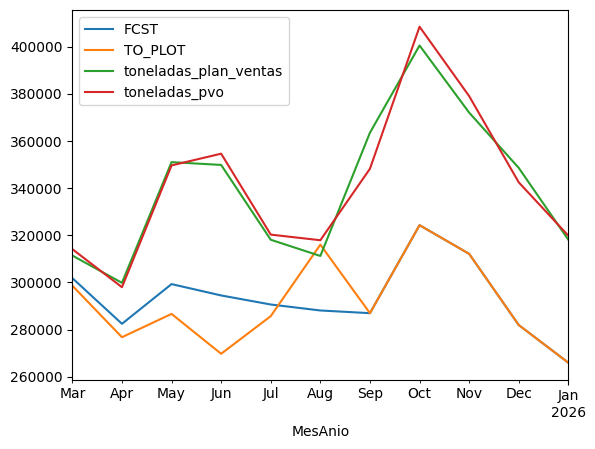

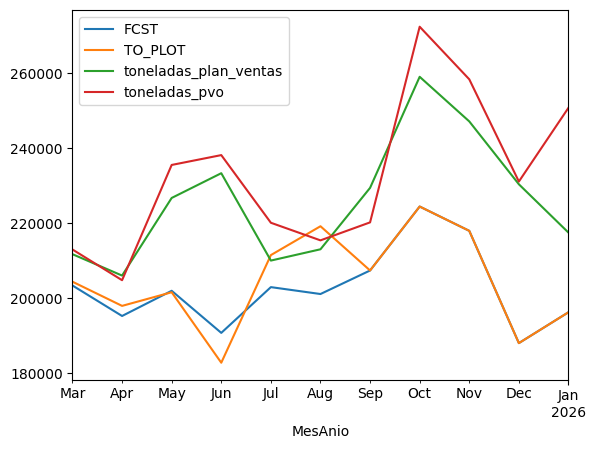

In [267]:
import matplotlib.pyplot as plt
df[  (df.MesAnio > "2025-02-03")].groupby("MesAnio").agg({"FCST":"sum", "TO_PLOT":"sum", "toneladas_plan_ventas":"sum", "toneladas_pvo":"sum"}).plot()
plt.show()
df[ (df.MAX_MODEL== True) & (df.MesAnio > "2025-02-03")].groupby("MesAnio").agg({"FCST":"sum", "TO_PLOT":"sum", "toneladas_plan_ventas":"sum", "toneladas_pvo":"sum"}).plot()
plt.show()

In [268]:
df[ (df.MesAnio > "2025-02-03")].groupby("MesAnio").agg({"FCST":"sum", "TO_PLOT":"sum", "toneladas_plan_ventas":"sum", "toneladas_pvo":"sum"})

,FCST,TO_PLOT,toneladas_plan_ventas,toneladas_pvo
MesAnio,,,,
2025-03-01,301825.123771,298605.668502,311391.500170,314116.19172
2025-04-01,282431.047698,276743.213118,299817.871770,297967.42046
2025-05-01,299281.431313,286633.726366,351031.823050,349645.48651
2025-06-01,294462.588438,269710.692785,349852.504730,354624.92090
2025-07-01,290623.403411,285686.192685,318095.420100,320277.35154
2025-08-01,288086.617095,316011.99387,311227.383510,317893.84368
2025-09-01,286944.66259,286944.66259,363531.113210,348232.53645
2025-10-01,324290.193841,324290.193841,400528.604115,408499.62931
2025-11-01,312124.559375,312124.559375,372052.628964,379054.97054
